In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#

In [604]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, make_scorer, f1_score

In [428]:
pd.set_option('display.float_format', '{:,.1f}'.format) #to set full numbers, not short version -Also with the , notation in numbers

In [ ]:
# Find optimal threshold using precision-recall curve
from sklearn.metrics import precision_recall_curve

In [429]:
ecom_df = pd.read_csv('ecom_df.csv')
ecom_df.head()

,date,productid,productname,storecode,storename,first_cat,second_cat,third_cat,industry,have_accountmanager,avg_item_price,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D
0,2020-11-11,"1,730,000,000,000,000,000.0",BĂNG ĐÔ rửa mặt phong cách hàn quốc dễ thương,VNLC3FWH8X,Tiip Gia Dụng,Fashion Accessories,Hair Accessories,Headbands,Fashion,0,0.8,1.5,1.5,0.0,0.0,1.5,0.0,0.0,0.0
1,2020-11-11,"1,730,000,000,000,000,000.0",Bổ Sung Vitamin Germomvit Khoáng Chất Cho Bà...,VNLCNYWLH4,Ba Nấm,Health,Food Supplements,Wellness Supplements,Personal Care & Health,1,11.6,23.3,11.1,12.2,0.0,23.3,0.0,0.0,0.0
2,2020-11-11,"1,730,000,000,000,000,000.0","CINE SET: bộ áo, váy thiết kế Charm By Tea.",VNLCKTWLY7,Charmbytea,Womenswear & Underwear,Women's Suits & Overalls,Sets,Fashion,1,16.3,16.3,16.3,0.0,0.0,0.0,16.3,0.0,0.0
3,2020-11-11,"1,730,000,000,000,000,000.0",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.3,30.7,0.0,0.0,30.7,0.0,0.0,0.0,0.0
4,2020-11-11,"1,730,000,000,000,000,000.0",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.6,15.6,0.0,0.0,0.0,15.6,0.0,15.6,15.6


In [430]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424544 entries, 0 to 2424543
Data columns (total 19 columns):
 #   Column               Dtype  
---  ------               -----  
 0   date                 object 
 1   productid            float64
 2   productname          object 
 3   storecode            object 
 4   storename            object 
 5   first_cat            object 
 6   second_cat           object 
 7   third_cat            object 
 8   industry             object 
 9   have_accountmanager  int64  
 10  avg_item_price       float64
 11  GMV                  float64
 12  GMV_marketplace      float64
 13  GMV_affiliate        float64
 14  GMV_live             float64
 15  GMV_product_card     float64
 16  GMV_video            float64
 17  GMV_Cancel_1D        float64
 18  GMV_Cancel_30D       float64
dtypes: float64(10), int64(1), object(8)
memory usage: 351.5+ MB


In [431]:
# Convert the 'date' column to datetime objects
ecom_df['date'] = pd.to_datetime(ecom_df['date'])

# Now you should be able to access the .dt accessor:
ecom_df['date'].dt.month.value_counts()

#Fix typo
ecom_df['second_cat'] = ecom_df['second_cat'].replace('Large & Home Appliances', 'Large Home Appliances')

# 0-Structure

0-Structure & Define Problems

1-EDA

2-Answer Questions: How much %Cancellation is considered as High

3-Data Transformation

4-Train Model

5-Evaluation

6-Interpreting & Actions

Define Problems:

* A big Online Supermarket - 'Economy Hub' (EH) faced an increasing %cancellation in every Double-Day Campaigns. This leaded to increasing cost of operations, delivery & impacted negatively on P&L (Profit & Loss) of the company
* EH after doing some interviews, realized 2 main reasons that could lead to this situation:

(1) Users are Resellers, who leveraged the vouchers in special campaigns to buy mobile phones & resell to other customers

(2) Some stores intentionally increased GMV (revenue) by fake orders to achieve target bonus, then cancelled

* Dataset: we have GMV performance of store level in D8 (Double-Day campaign 8.8), 1 to 30.9, D10, D11, D12 and 6-11.12 of Year 2020


* Requirement:

(1) Identify which %Cancellation rate is highly alarmed!

(2) Build ML models to predict stores that likely to have High Cancellation Rate

(3) Evaluate different model performance and translate into insights, what features that detect the most likely high %cancellation rate and recommendations

# 1-EDA

In [432]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424544 entries, 0 to 2424543
Data columns (total 19 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   productid            float64       
 2   productname          object        
 3   storecode            object        
 4   storename            object        
 5   first_cat            object        
 6   second_cat           object        
 7   third_cat            object        
 8   industry             object        
 9   have_accountmanager  int64         
 10  avg_item_price       float64       
 11  GMV                  float64       
 12  GMV_marketplace      float64       
 13  GMV_affiliate        float64       
 14  GMV_live             float64       
 15  GMV_product_card     float64       
 16  GMV_video            float64       
 17  GMV_Cancel_1D        float64       
 18  GMV_Cancel_30D       float64       
dtypes: datetime64[ns](1),

Features Explaination:
* first_cat, second_cat: level of product categories
* is_having_accountmanager: that store is managed by an Account Manager from EH. Yes = 1, No = 0
* GMV: Revenue, GMV_after_1D: GMV minus cancellation after 1 day, GMV_after_30D: after 30 days
* GMV_marketplace: GMV from listing channel. Remember: GMV include many channels - Livestream, Marketplace, Affiliate, etc.
* GMV_affiliate: GMV from affiliate channel - KOL/KOC's livestreaming, etc.

In [433]:
 ecom_df.describe()

,date,productid,have_accountmanager,avg_item_price,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D
count,2424544,"2,424,544.0","2,424,544.0","2,424,163.0","2,424,544.0","2,424,544.0","2,424,544.0","2,424,544.0","2,424,544.0","2,424,544.0","2,424,544.0","2,424,544.0"
mean,2020-11-01 02:49:00.350020864,"1,729,965,493,222,642,944.0",0.7,8.7,39.7,9.6,14.0,18.8,13.5,7.4,8.5,11.1
min,2020-08-08 00:00:00,"1,729,380,000,000,000,000.0",0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
25%,2020-09-21 00:00:00,"1,730,000,000,000,000,000.0",0.0,2.9,4.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,2020-11-11 00:00:00,"1,730,000,000,000,000,000.0",1.0,5.3,8.3,0.0,0.0,0.0,2.3,0.0,0.0,0.0
75%,2020-12-07 00:00:00,"1,730,000,000,000,000,000.0",1.0,8.8,20.5,5.6,2.6,3.4,7.9,1.2,2.4,4.6
max,2020-12-12 00:00:00,"1,730,000,000,000,000,000.0",1.0,"4,391.0","489,290.9","237,988.3","87,385.3","445,843.1","237,944.7","45,412.2","68,899.7","68,899.7"
std,NaN,"110,570,001,229,455.9",0.4,24.5,704.0,316.2,208.3,577.5,315.5,85.1,149.0,177.7


Questions in mind:
- GMV by Cat: What is the structure of First Cat- Second Cat, What are the most selling cat, Are there different by trend?
- How many stores have account manager
- What are the GMV trend in each D-Day campaigns, from 8.8 to 12.12? Same with GMV_marketplace, affiliate and orders
- Is there anything about AOV differences (Average Order Value = GMV / Orders)
- What is the cancellation trend (after_1D, after_30D) between normal days, and D-Day campaigns
- Should we segment GMV by tier?

## 1-1 GMV by Industry - First Cat

In [434]:
#Structure of First Cat - Second Cat
GMV_By_First_Cat = ecom_df.groupby(['industry', 'first_cat']).agg({'GMV': 'sum'})/ ( ecom_df['GMV'].sum() ) * 100
GMV_By_First_Cat.sort_values(by=['industry', 'GMV'], ascending=False)

GMV
industry               first_cat                             
Personal Care & Health Beauty & Personal Care             5.1
                       Health                             2.3
                       Home Supplies                      0.3
Mom & Babies           Baby & Maternity                   5.0
                       Kids' Fashion                      1.0
                       Toys & Hobbies                     0.3
Home & Living          Automotive & Motorcycle            1.5
                       Home Supplies                      1.2
                       Textiles & Soft Furnishings        1.1
                       Kitchenware                        0.8
                       Home Improvement                   0.7
                       Tools & Hardware                   0.6
                       Pet Supplies                       0.4
                       Furniture                          0.4
                       Toys & Hobbies                     0.2
                       Sports & Outdoor                   0.1
                       Collectibles                       0.0
Grocery                Food & Beverages                   3.6
                       Books, Magazines & Audio           0.3
                       Computers & Office Equipment       0.3
                       Home Supplies                      0.3
                       Fashion Accessories                0.0
                       Toys & Hobbies                     0.0
Fashion                Womenswear & Underwear            13.0
                       Menswear & Underwear               6.4
                       Shoes                              2.7
                       Sports & Outdoor                   2.6
                       Fashion Accessories                1.6
                       Luggage & Bags                     1.5
                       Jewelry Accessories & Derivatives  0.3
                       Muslim Fashion                     0.0
Electronics            Phones & Electronics              24.7
                       Household Appliances              11.3
                       Computers & Office Equipment       2.7
Beauty                 Beauty & Personal Care             7.5

- We see that from this dataset, Fashion & Electronics contribute the most GMV, - In Electronics - Phones is 24% GMV and Household Applianices is 11%
- In Fashion it is Womenswear 13%, Menswear 6%
- After that, we have Beauty 7.5% - Personal Care & Health also 7.5%
- Other industries seems to be small


In [435]:
#Lets see GMV Industry Trend

GMV_By_industry_Trend = ecom_df.groupby(['industry', 'date']).agg({'GMV': 'sum'}).unstack().T.droplevel(0) #unstack to unpivot, T to transpose, droplevel(0) to drop the 1st column GMV name (no need)

In [436]:
GMV_By_industry_Trend.head(50)

industry,Beauty,Electronics,Fashion,Grocery,Home & Living,Mom & Babies,Personal Care & Health
date,,,,,,,
2020-08-08,"357,334.2","238,161.2","1,134,613.8","207,178.1","252,949.6","209,979.4","362,678.6"
2020-09-01,NaN,"423,004.1",NaN,NaN,NaN,NaN,NaN
2020-09-02,NaN,"380,109.0",NaN,NaN,NaN,NaN,NaN
2020-09-03,NaN,"383,664.8",NaN,NaN,NaN,NaN,NaN
2020-09-04,NaN,"459,736.0",NaN,NaN,NaN,NaN,NaN
2020-09-05,NaN,"480,091.6",NaN,NaN,NaN,NaN,NaN
2020-09-06,NaN,"718,355.3",NaN,NaN,NaN,NaN,NaN
2020-09-07,NaN,"777,294.1",NaN,NaN,NaN,NaN,NaN
2020-09-08,NaN,"1,109,210.3",NaN,NaN,NaN,NaN,NaN


In [437]:
GMV_By_industry_Trend.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39 entries, 2020-08-08 to 2020-12-12
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Beauty                  7 non-null      float64
 1   Electronics             39 non-null     float64
 2   Fashion                 7 non-null      float64
 3   Grocery                 7 non-null      float64
 4   Home & Living           7 non-null      float64
 5   Mom & Babies            7 non-null      float64
 6   Personal Care & Health  7 non-null      float64
dtypes: float64(7)
memory usage: 2.4 KB


We realize that only Electronics have GMV for the whole Sep, while other industries have GMV in only campaigns D9 (9.9.20) --> Suggest to remove to make it more relevant to forecast only Cancellation rate in Campaign Days

In [438]:
GMV_By_industry_Trend.dropna(inplace = True)

In [439]:
GMV_By_industry_Trend['total_GMV'] = GMV_By_industry_Trend['Beauty'] + GMV_By_industry_Trend['Electronics'] + GMV_By_industry_Trend['Fashion'] + GMV_By_industry_Trend['Grocery']  + GMV_By_industry_Trend['Home & Living'] + GMV_By_industry_Trend['Mom & Babies'] + + GMV_By_industry_Trend['Personal Care & Health']

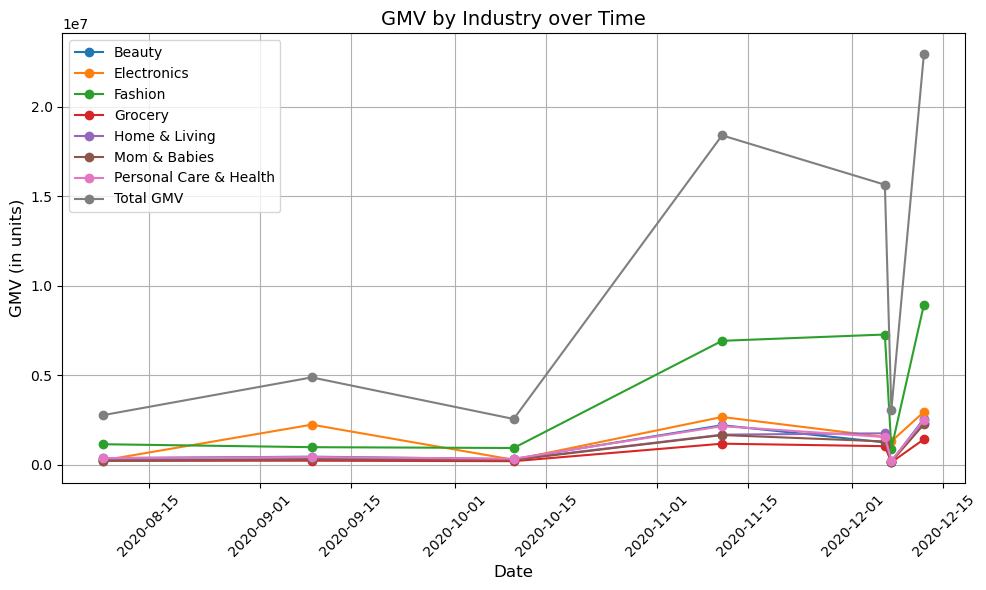

In [440]:
df = GMV_By_industry_Trend
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Beauty'], marker='o', label='Beauty')
plt.plot(df.index, df['Electronics'], marker='o', label='Electronics')
plt.plot(df.index, df['Fashion'], marker='o', label='Fashion')
plt.plot(df.index, df['Grocery'], marker='o', label='Grocery')
plt.plot(df.index, df['Home & Living'], marker='o', label='Home & Living')
plt.plot(df.index, df['Mom & Babies'], marker='o', label='Mom & Babies')
plt.plot(df.index, df['Personal Care & Health'], marker='o', label='Personal Care & Health')
plt.plot(df.index, df['total_GMV'], marker='o', label='Total GMV')

# Beautifying the plot
plt.title('GMV by Industry over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('GMV (in units)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

P/s: Remember that it is not continuous. We have 8.8, 9.9, then 10.10, 11.11, 6-7.16 and 12.12

In [441]:
#I dont want to show e+06 in the .head, I want to see full with ,
GMV_By_industry_Trend.head(10).style.format('{:,.0f}')

industry,Beauty,Electronics,Fashion,Grocery,Home & Living,Mom & Babies,Personal Care & Health,total_GMV
date,,,,,,,,
2020-08-08 00:00:00,"357,334","238,161","1,134,614","207,178","252,950","209,979","362,679","2,762,895"
2020-09-09 00:00:00,"439,677","2,227,995","969,928","214,138","309,273","288,786","418,779","4,868,577"
2020-10-10 00:00:00,"302,280","265,840","923,753","187,924","283,897","257,730","324,092","2,545,515"
2020-11-11 00:00:00,"2,197,458","2,656,778","6,912,429","1,165,086","1,669,093","1,647,773","2,142,580","18,391,197"
2020-12-06 00:00:00,"1,235,895","1,536,793","7,264,167","1,025,287","1,744,373","1,290,007","1,537,849","15,634,369"
2020-12-07 00:00:00,"167,765","1,291,341","888,747","125,261","216,991","160,130","204,332","3,054,568"
2020-12-12 00:00:00,"2,561,609","2,943,140","8,936,983","1,414,098","2,339,640","2,250,340","2,504,449","22,950,259"


Overall, from here we see that very strange movement:
- We start very low in 8.8, 2,7M and and x2 in 9.9 up to 4.8M USD - 50% contributed from Electronics!!!
- Then we see 10.10, we decreased again -2x to 2.5M USD
- 11.11, 6.12 and 12.12 we see a big push of D-Day, respectively 18.4M, 15.6M & 22.9M - Awesome!!!
- 7.12 is just a normal day after campaigns, but still 3M!

From the research with the team, 8.8 was not the peak sales of E-commerce yet, and 10.10 we faced a major system collapse! Thats why we see so low GMV from D8 and D10

About Industry level, we see that big push of GMV coming from Electromics and Fashion.
- Especially Fashion in D11 and D12 (up to 7-9M GMV - contribute 40-50% GMV of campaigns)
- Electronics is also a star in 9.9 when reached 2M GMV while other is only below 1M. Based on market insights, there is a new Iphone Product Launch so many customers pre-order on EH platform
- Other industry perform around 2-2.5M in D12 campaigns


## 1-2 GMV marketplace, affiliate and orders trend

In [442]:
#Structure of GMV Contribution
GMV_By_industry_Cont = ecom_df.groupby(['industry']).agg({'GMV': 'sum', 'GMV_affiliate': 'sum', 'GMV_marketplace': 'sum'})/ ( ecom_df['GMV'].sum() ) * 100
GMV_By_industry_Cont.sort_values(by=['GMV'], ascending=False)

,GMV,GMV_affiliate,GMV_marketplace
industry,,,
Electronics,38.7,13.8,10.0
Fashion,28.1,9.4,6.7
Personal Care & Health,7.8,3.0,1.7
Beauty,7.5,3.4,1.5
Home & Living,7.1,2.0,1.8
Mom & Babies,6.3,2.1,1.6
Grocery,4.5,1.5,0.9


In this way, we can interpret that:
- Affiliate contribute 35% GMV, while Marketplace contribute 25%. So in this business, we were quite rely heavily on Affiliate (have to pay much to KOL/KOC for affiliate revenue - which contribute 1/3 of our GMV)
- Marketplace channel is still weak. This one is the way that we grow GMV by ourselves but only contribute 1/4 GMV

In [443]:
#Lets see the trend in D-Day campaigns
GMV_affliate_By_First_Cat_Trend = ( ecom_df.groupby(['first_cat', 'date']).agg({'GMV_affiliate': 'sum', 'GMV': 'sum'})
)

In [444]:
GMV_affliate_By_First_Cat_Trend['pct_affiliate'] = GMV_affliate_By_First_Cat_Trend['GMV_affiliate'] / GMV_affliate_By_First_Cat_Trend['GMV'] * 100

In [445]:
#Need to do more

## 1-3 GMV cancellation trend, is there any different between having account manager or not?

### 1-3-1 Calculate Overall Cancellation trend by date

In [446]:
#Calculate cancellation trend in overall level, GMV_after_1D, GMV_after_30D

In [447]:
ecom_df.head()

,date,productid,productname,storecode,storename,first_cat,second_cat,third_cat,industry,have_accountmanager,avg_item_price,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D
0,2020-11-11,"1,730,000,000,000,000,000.0",BĂNG ĐÔ rửa mặt phong cách hàn quốc dễ thương,VNLC3FWH8X,Tiip Gia Dụng,Fashion Accessories,Hair Accessories,Headbands,Fashion,0,0.8,1.5,1.5,0.0,0.0,1.5,0.0,0.0,0.0
1,2020-11-11,"1,730,000,000,000,000,000.0",Bổ Sung Vitamin Germomvit Khoáng Chất Cho Bà...,VNLCNYWLH4,Ba Nấm,Health,Food Supplements,Wellness Supplements,Personal Care & Health,1,11.6,23.3,11.1,12.2,0.0,23.3,0.0,0.0,0.0
2,2020-11-11,"1,730,000,000,000,000,000.0","CINE SET: bộ áo, váy thiết kế Charm By Tea.",VNLCKTWLY7,Charmbytea,Womenswear & Underwear,Women's Suits & Overalls,Sets,Fashion,1,16.3,16.3,16.3,0.0,0.0,0.0,16.3,0.0,0.0
3,2020-11-11,"1,730,000,000,000,000,000.0",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.3,30.7,0.0,0.0,30.7,0.0,0.0,0.0,0.0
4,2020-11-11,"1,730,000,000,000,000,000.0",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.6,15.6,0.0,0.0,0.0,15.6,0.0,15.6,15.6


In [448]:
ecom_df_date = ecom_df.groupby(['date']).agg({'GMV': 'sum', 'GMV_Cancel_1D': 'sum', 'GMV_Cancel_30D': 'sum'})
ecom_df_date.head()

,GMV,GMV_Cancel_1D,GMV_Cancel_30D
date,,,
2020-08-08,"2,762,894.8","568,660.0","749,559.4"
2020-09-01,"423,004.1","88,831.1","145,202.9"
2020-09-02,"380,109.0","83,526.9","119,836.3"
2020-09-03,"383,664.8","87,413.5","121,417.9"
2020-09-04,"459,736.0","103,489.4","145,389.0"


In [449]:
#calculate contribution by date level
ecom_df_date['GMV_Cancel_1D_pct'] = ecom_df_date['GMV_Cancel_1D'] / ecom_df_date['GMV'] * 100
ecom_df_date['GMV_Cancel_30D_pct'] = ecom_df_date['GMV_Cancel_30D'] / ecom_df_date['GMV'] * 100

In [450]:
ecom_df_date.head(50)

,GMV,GMV_Cancel_1D,GMV_Cancel_30D,GMV_Cancel_1D_pct,GMV_Cancel_30D_pct
date,,,,,
2020-08-08,"2,762,894.8","568,660.0","749,559.4",20.6,27.1
2020-09-01,"423,004.1","88,831.1","145,202.9",21.0,34.3
2020-09-02,"380,109.0","83,526.9","119,836.3",22.0,31.5
2020-09-03,"383,664.8","87,413.5","121,417.9",22.8,31.6
2020-09-04,"459,736.0","103,489.4","145,389.0",22.5,31.6
2020-09-05,"480,091.6","112,994.1","159,602.1",23.5,33.2
2020-09-06,"718,355.3","186,341.5","245,838.2",25.9,34.2
2020-09-07,"777,294.1","181,102.6","245,818.8",23.3,31.6
2020-09-08,"1,109,210.3","274,571.0","362,468.3",24.8,32.7


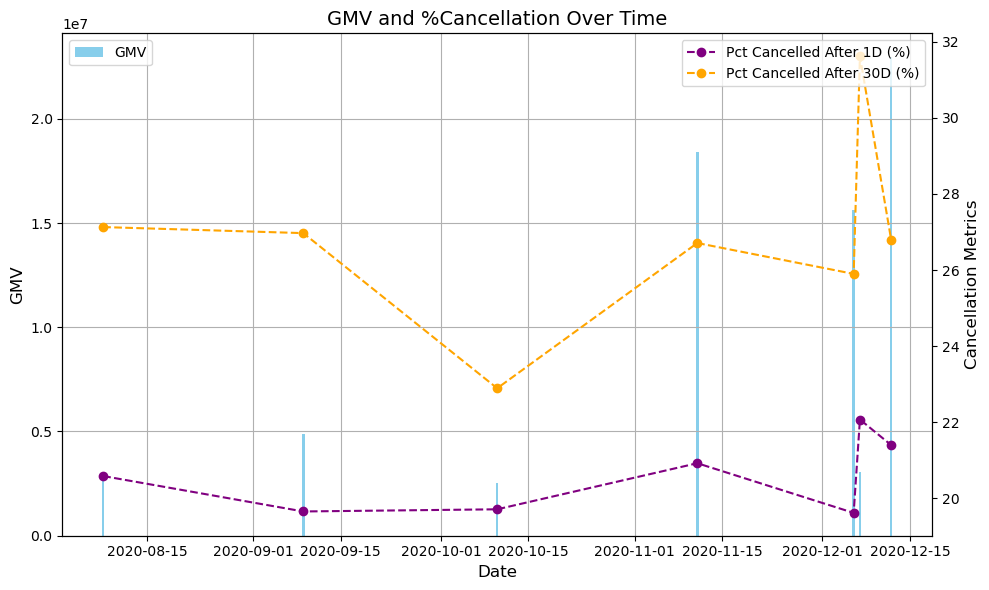

In [451]:
#Now, visualize GMV as bar chart by date, and 2 lines pct_cancelled_after_1D, pct_cancelled_after_30D - Only Take Campaigns Date
campaign_date = ['2020-08-08', '2020-09-09', '2020-10-10', '2020-11-11', '2020-12-06', '2020-12-07', '2020-12-12']

df = ecom_df_date.loc[campaign_date]

# Create a figure and axis with twin y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot GMV as bar chart
ax1.bar(df.index, df['GMV'], color='skyblue', label='GMV', width=0.4)

# Create a secondary y-axis for the lines
ax2 = ax1.twinx()

# Plot the other columns as lines
ax2.plot(df.index, df['GMV_Cancel_1D_pct'], marker='o', label='Pct Cancelled After 1D (%)', color='purple', linestyle='--')
ax2.plot(df.index, df['GMV_Cancel_30D_pct'], marker='o', label='Pct Cancelled After 30D (%)', color='orange', linestyle='--')

# Beautifying the plot
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('GMV', fontsize=12)
ax2.set_ylabel('Cancellation Metrics', fontsize=12)

# Title
plt.title('GMV and %Cancellation Over Time', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adding legends for both plots
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Grid for better readability
ax1.grid(True)

plt.tight_layout()
plt.show()

In [452]:
df.head(10)

,GMV,GMV_Cancel_1D,GMV_Cancel_30D,GMV_Cancel_1D_pct,GMV_Cancel_30D_pct
date,,,,,
2020-08-08,"2,762,894.8","568,660.0","749,559.4",20.6,27.1
2020-09-09,"4,868,577.4","956,701.2","1,313,071.5",19.7,27.0
2020-10-10,"2,545,514.9","501,654.5","582,670.1",19.7,22.9
2020-11-11,"18,391,197.0","3,847,287.7","4,912,243.0",20.9,26.7
2020-12-06,"15,634,369.5","3,066,381.4","4,049,016.3",19.6,25.9
2020-12-07,"3,054,568.2","674,103.5","965,972.2",22.1,31.6
2020-12-12,"22,950,259.3","4,910,303.9","6,148,228.6",21.4,26.8


In [453]:
#Campaign avg. cancellation rate
df.agg({'GMV_Cancel_1D_pct': 'mean', 'GMV_Cancel_30D_pct': 'mean'})

GMV_Cancel_1D_pct    20.6
GMV_Cancel_30D_pct   26.9
dtype: float64

In [454]:
#calculate average cancellation rate in  Normal Date, note Campaign Date
ecom_df_date.loc[
    ((ecom_df_date.index >= '2020-09-01') & (ecom_df_date.index <= '2020-09-08')) |
    ((ecom_df_date.index >= '2020-09-10') & (ecom_df_date.index <= '2020-09-30')) |
    ((ecom_df_date.index >= '2020-12-07') & (ecom_df_date.index <= '2020-12-11'))
].agg({'GMV_Cancel_1D_pct': 'mean', 'GMV_Cancel_30D_pct': 'mean'})

GMV_Cancel_1D_pct    23.4
GMV_Cancel_30D_pct   31.3
dtype: float64

Taking Avg. seems not so trustful, because seems Cancellation rate in Campaigns is lower than normal days:
- Normal GMV_Cancel_1D_pct could be 23%, GMV_Cancel_30D_pct is 31%
- In Campaigns, GMV_Cancel_1D_pct is 20%, GMV_Cancel_30D_pct is 27%

Trend of Cancellation in Campaigns Day:
- The trend of GMV_Cancel_1D_pct in Campaigns days is relatively 20%, but increase in D11 & D12, reaching 22% in D12
- D10 cancellation after 30D is suddenly low at 23% - for the technical issues happenning so it is better than usual. I believe that it should be 26-27% in campaigns. It is very high - 32% in 7.12 (what happenned?)

First assumptions: GMV_Cancel_30D_pct: lets take **30% as Warning Threshold**

### 1-3-3 Is cancellation rate different between having_account_managers or not?

Will do later

# 2-Answer Questions: How much %Cancellation is considered as High

In [455]:
ecom_df.head()

,date,productid,productname,storecode,storename,first_cat,second_cat,third_cat,industry,have_accountmanager,avg_item_price,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D
0,2020-11-11,"1,730,000,000,000,000,000.0",BĂNG ĐÔ rửa mặt phong cách hàn quốc dễ thương,VNLC3FWH8X,Tiip Gia Dụng,Fashion Accessories,Hair Accessories,Headbands,Fashion,0,0.8,1.5,1.5,0.0,0.0,1.5,0.0,0.0,0.0
1,2020-11-11,"1,730,000,000,000,000,000.0",Bổ Sung Vitamin Germomvit Khoáng Chất Cho Bà...,VNLCNYWLH4,Ba Nấm,Health,Food Supplements,Wellness Supplements,Personal Care & Health,1,11.6,23.3,11.1,12.2,0.0,23.3,0.0,0.0,0.0
2,2020-11-11,"1,730,000,000,000,000,000.0","CINE SET: bộ áo, váy thiết kế Charm By Tea.",VNLCKTWLY7,Charmbytea,Womenswear & Underwear,Women's Suits & Overalls,Sets,Fashion,1,16.3,16.3,16.3,0.0,0.0,0.0,16.3,0.0,0.0
3,2020-11-11,"1,730,000,000,000,000,000.0",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.3,30.7,0.0,0.0,30.7,0.0,0.0,0.0,0.0
4,2020-11-11,"1,730,000,000,000,000,000.0",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.6,15.6,0.0,0.0,0.0,15.6,0.0,15.6,15.6


In [456]:
#aggregrate by storecode and date
store_df = ecom_df.groupby(['date', 'storecode']).agg({'GMV': 'sum', 'GMV_Cancel_1D': 'sum', 'GMV_Cancel_30D': 'sum'})
store_df.head()

GMV  GMV_Cancel_1D  GMV_Cancel_30D
date       storecode                                     
2020-08-08 VNLC22LLGV  8.1            0.0             0.0
           VNLC22LLMW 21.5            0.0             0.0
           VNLC22LLUM 23.2            0.0            23.2
           VNLC22LLUN 54.6           10.2            10.2
           VNLC22W2TC  2.9            0.0             2.9

In [457]:
#calculate pct
store_df['GMV_Cancel_1D_pct'] = store_df['GMV_Cancel_1D'] / store_df['GMV'] * 100
store_df['GMV_Cancel_30D_pct'] = store_df['GMV_Cancel_30D'] / store_df['GMV'] * 100
store_df.head()

GMV  GMV_Cancel_1D  GMV_Cancel_30D  GMV_Cancel_1D_pct  \
date       storecode                                                           
2020-08-08 VNLC22LLGV  8.1            0.0             0.0                0.0   
           VNLC22LLMW 21.5            0.0             0.0                0.0   
           VNLC22LLUM 23.2            0.0            23.2                0.0   
           VNLC22LLUN 54.6           10.2            10.2               18.7   
           VNLC22W2TC  2.9            0.0             2.9                0.0   

                       GMV_Cancel_30D_pct  
date       storecode                       
2020-08-08 VNLC22LLGV                 0.0  
           VNLC22LLMW                 0.0  
           VNLC22LLUM               100.0  
           VNLC22LLUN                18.7  
           VNLC22W2TC               100.0

In [458]:
#reset the index to make 'date' and 'storecode' regular columns:
store_df = store_df.reset_index()
store_df.head()

,date,storecode,GMV,GMV_Cancel_1D,GMV_Cancel_30D,GMV_Cancel_1D_pct,GMV_Cancel_30D_pct
0,2020-08-08,VNLC22LLGV,8.1,0.0,0.0,0.0,0.0
1,2020-08-08,VNLC22LLMW,21.5,0.0,0.0,0.0,0.0
2,2020-08-08,VNLC22LLUM,23.2,0.0,23.2,0.0,100.0
3,2020-08-08,VNLC22LLUN,54.6,10.2,10.2,18.7,18.7
4,2020-08-08,VNLC22W2TC,2.9,0.0,2.9,0.0,100.0


In [459]:
store_df['date'] = pd.to_datetime(store_df['date'])

Now lets see the Cancellation rate of D-Day

In [460]:
#take only the D-Day campaign
store_df_dday = store_df[store_df['date'].isin(campaign_date)]
store_df_dday.describe()

,date,GMV,GMV_Cancel_1D,GMV_Cancel_30D,GMV_Cancel_1D_pct,GMV_Cancel_30D_pct
count,284785,"284,785.0","284,785.0","284,785.0","284,467.0","284,467.0"
mean,2020-11-05 21:51:10.615376384,246.5,51.0,65.7,15.0,23.5
min,2020-08-08 00:00:00,0.0,0.0,0.0,0.0,0.0
25%,2020-10-10 00:00:00,8.4,0.0,0.0,0.0,0.0
50%,2020-12-06 00:00:00,24.2,0.0,4.2,0.0,11.6
75%,2020-12-07 00:00:00,96.2,14.4,20.7,19.4,32.3
max,2020-12-12 00:00:00,"394,127.6","105,669.6","115,828.0",100.0,100.0
std,NaN,"2,330.9",659.0,775.0,25.1,31.7


(array([154513.,  17846.,  23041.,  20046.,  13965.,   9595.,   7391.,
          4985.,   3557.,   3477.,   5004.,   1722.,   1306.,   1336.,
           792.,    597.,    395.,    269.,    194.,  14436.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

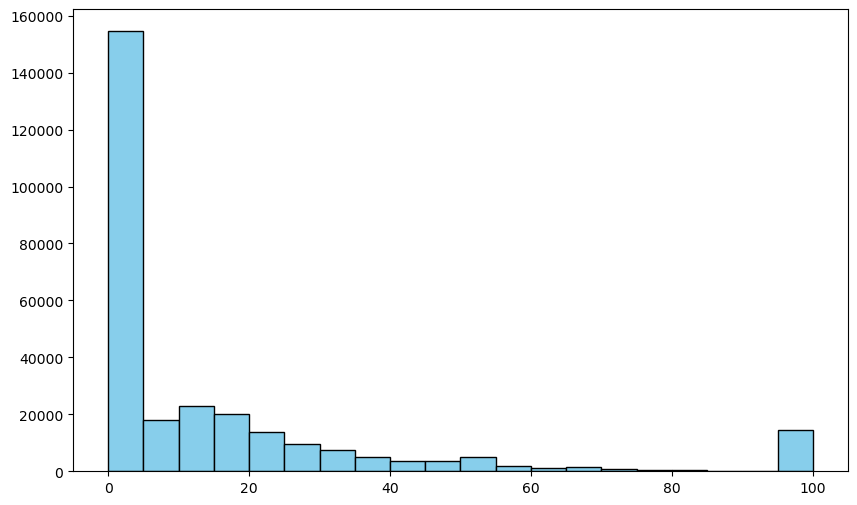

In [461]:
#draw a histogram to see how many stores with different pct_cancelled_after_1D
plt.figure(figsize=(10, 6))
plt.hist(store_df_dday['GMV_Cancel_1D_pct'], bins=20, color='skyblue', edgecolor='black')

(array([124528.,  12072.,  18889.,  21234.,  17980.,  13727.,  10499.,
          7577.,   5457.,   5102.,   6442.,   2696.,   2127.,   2091.,
          1382.,   1057.,    725.,    506.,    318.,  30058.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

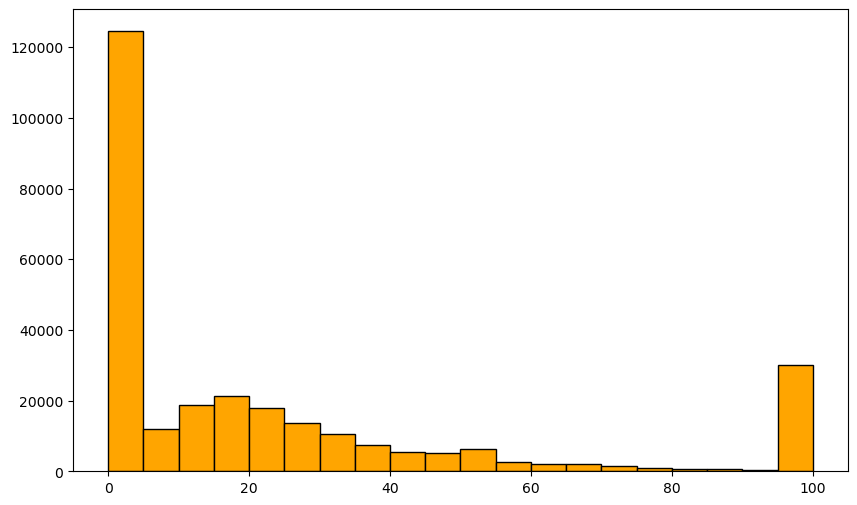

In [462]:
#draw a histogram to see how many stores with different GMV_Cancel_30D_pct
plt.figure(figsize=(10, 6))
plt.hist(store_df_dday['GMV_Cancel_30D_pct'], bins=20, color='orange', edgecolor='black')

In [463]:
#Group by 10-20-30% etc.
pct_group = [0, 10, 20, 30, 40, 50, 80 , 100]

store_df_dday['GMV_Cancel_1D_pct_group'] = pd.cut(store_df_dday['GMV_Cancel_1D_pct'], bins=pct_group, labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-80%', '80-100%'])
store_df_dday['GMV_Cancel_30D_pct_group'] = pd.cut(store_df_dday['GMV_Cancel_30D_pct'], bins=pct_group, labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-80%', '80-100%'])

round(store_df_dday['GMV_Cancel_1D_pct_group'].value_counts()/store_df_dday['GMV_Cancel_1D_pct_group'].value_counts().sum() * 100,1)

GMV_Cancel_1D_pct_group
10-20%    31.7
0-10%     17.6
20-30%    17.3
80-100%   11.2
30-40%     9.1
50-80%     6.7
40-50%     6.4
Name: count, dtype: float64

In [464]:
round(store_df_dday['GMV_Cancel_30D_pct_group'].value_counts()/store_df_dday['GMV_Cancel_30D_pct_group'].value_counts().sum() * 100,1)

GMV_Cancel_30D_pct_group
10-20%    24.6
20-30%    19.4
80-100%   19.3
30-40%    11.1
0-10%      9.5
50-80%     8.6
40-50%     7.5
Name: count, dtype: float64

Interesting!
- After 1 Day, 65% stores have cancellation ratebelow 30%. There always special group with cancellation rate 80%+
- After 30 Days, the cancellation rate increased, Notably 20%% stores have 80%+. Around 47% stores have cancellation rate from 30-80%
---> To make an aggressive control, I propose we set **Stores with Cancellation rate 30%+** after 30 Days should be Warning!

Second Assumption: Lets Take Cancellation **from 30%+ after 30D as Alarming Rate!**

# 3-Data Transformation

In [465]:
#Now We need to transform the data to fit for training model
ecom_df.head()

,date,productid,productname,storecode,storename,first_cat,second_cat,third_cat,industry,have_accountmanager,avg_item_price,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D
0,2020-11-11,"1,730,000,000,000,000,000.0",BĂNG ĐÔ rửa mặt phong cách hàn quốc dễ thương,VNLC3FWH8X,Tiip Gia Dụng,Fashion Accessories,Hair Accessories,Headbands,Fashion,0,0.8,1.5,1.5,0.0,0.0,1.5,0.0,0.0,0.0
1,2020-11-11,"1,730,000,000,000,000,000.0",Bổ Sung Vitamin Germomvit Khoáng Chất Cho Bà...,VNLCNYWLH4,Ba Nấm,Health,Food Supplements,Wellness Supplements,Personal Care & Health,1,11.6,23.3,11.1,12.2,0.0,23.3,0.0,0.0,0.0
2,2020-11-11,"1,730,000,000,000,000,000.0","CINE SET: bộ áo, váy thiết kế Charm By Tea.",VNLCKTWLY7,Charmbytea,Womenswear & Underwear,Women's Suits & Overalls,Sets,Fashion,1,16.3,16.3,16.3,0.0,0.0,0.0,16.3,0.0,0.0
3,2020-11-11,"1,730,000,000,000,000,000.0",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.3,30.7,0.0,0.0,30.7,0.0,0.0,0.0,0.0
4,2020-11-11,"1,730,000,000,000,000,000.0",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.6,15.6,0.0,0.0,0.0,15.6,0.0,15.6,15.6


In [466]:
ecom_df['date'] = pd.to_datetime(ecom_df['date'])

In [467]:
ecom_df['date'].dt.month.value_counts()

date
12    1119094
11     419348
9      417909
8      241531
10     226662
Name: count, dtype: int64

- Around 1.1M (46%) rows for December, and 1.3M (54%) rows from Aug to Nov.
- We may need to divide Dec to get smaller set of data, so Train 70%, Test 30%

In [468]:
ecom_df[ecom_df['date'].dt.month == 12]['date'].dt.day.value_counts()

date
12    515071
6     450620
7      76089
11     21830
10     18849
8      18366
9      18269
Name: count, dtype: int64

I realize we can do like this:
- Train set: Up to 6.12 (72%)
- Test set: From 7 - 12.12 (28%)

We see some steps to do:

- Drop unneeded features and group by: in this model, I want to keep level by date, storecode and first, second, third cat. Avg_Item_price --> I suggest to convert into Total_Items (by GMV / Avg_Item_Price)
- GMV_ features: they should be in % of GMV
- Label Target: store with 30% cancellation rate is high alarmed. We can create a label feature high_cancel_30% - Yes = 1, else 0. From that - see how many High Cancel in each time period ---> To see any imbalance in the dataset
- Train / Test set: do as above
- Category Encoding: industry, first_cate, second_cat, third_cat. Because each row is in product-level. Because these hierachy layers are having highly cardinality, I suggest to do Mean Encoding (which is target the average cancellation rate). The question now is: What to do with the Test data (where in the future, we dont know how much %cancellation rate) - So it is the Data leakage problem. This way, I suggest to put the mean encoding of the training set to the test set

Questions: Should we do Train / Test splitting before Label Target? Should it be any influential between 2 sets
- I dont think so, because we will set High_Cancellation_rate of store level in date level!
- So if Store A in 9.9 have 30% cancellation rate --> Will mark as high. But in 10.10 can be lower
- We will remove date and store feature in the model training. So dont care about specific 1 store

One more thing: to avoid outliers, we can log GMV, but lets see in the model performance first if this step is necessary or not?

## 3-0 Drop unnecessary features and group by - Important Point - Decide how many Features we have (*)

In [469]:
x = ecom_df.copy()
x.head()

,date,productid,productname,storecode,storename,first_cat,second_cat,third_cat,industry,have_accountmanager,avg_item_price,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D
0,2020-11-11,"1,730,000,000,000,000,000.0",BĂNG ĐÔ rửa mặt phong cách hàn quốc dễ thương,VNLC3FWH8X,Tiip Gia Dụng,Fashion Accessories,Hair Accessories,Headbands,Fashion,0,0.8,1.5,1.5,0.0,0.0,1.5,0.0,0.0,0.0
1,2020-11-11,"1,730,000,000,000,000,000.0",Bổ Sung Vitamin Germomvit Khoáng Chất Cho Bà...,VNLCNYWLH4,Ba Nấm,Health,Food Supplements,Wellness Supplements,Personal Care & Health,1,11.6,23.3,11.1,12.2,0.0,23.3,0.0,0.0,0.0
2,2020-11-11,"1,730,000,000,000,000,000.0","CINE SET: bộ áo, váy thiết kế Charm By Tea.",VNLCKTWLY7,Charmbytea,Womenswear & Underwear,Women's Suits & Overalls,Sets,Fashion,1,16.3,16.3,16.3,0.0,0.0,0.0,16.3,0.0,0.0
3,2020-11-11,"1,730,000,000,000,000,000.0",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.3,30.7,0.0,0.0,30.7,0.0,0.0,0.0,0.0
4,2020-11-11,"1,730,000,000,000,000,000.0",Combo 2sp Bakuchiol 1% + Bakuchiol 5% -Derma ...,VNLCL2WLKH,Onni Cosmetic.vn,Beauty & Personal Care,Skincare,Skin Care Kits,Beauty,1,15.6,15.6,0.0,0.0,0.0,15.6,0.0,15.6,15.6


In [470]:
#calculate total_items
x['total_items'] = x['GMV'] / x['avg_item_price']

In [471]:
x.columns

Index(['date', 'productid', 'productname', 'storecode', 'storename',
       'first_cat', 'second_cat', 'third_cat', 'industry',
       'have_accountmanager', 'avg_item_price', 'GMV', 'GMV_marketplace',
       'GMV_affiliate', 'GMV_live', 'GMV_product_card', 'GMV_video',
       'GMV_Cancel_1D', 'GMV_Cancel_30D', 'total_items'],
      dtype='object')

Now we need to think about how many features should we encode, so we will group by:

In [472]:
x['first_cat'].nunique()

27

In [473]:
x['second_cat'].nunique()

194

In [474]:
x['third_cat'].nunique()

1410

We have even up to 193 Second_Cat. So we have 2 choices:
- Run up to 27 First Cat only
- Or run up to 193 Second Cat - I wonder if this will be overfit the model?
---> Lets take a safe choice first - 27 First Cat only!

In [475]:
#Group by
cat_col = ['date', 'storecode',
       'first_cat', 'industry', 'second_cat', 'third_cat',
       'have_accountmanager'] #We wont take 'second_cat', 'third_cat', as so many of them

num_col = ['GMV', 'GMV_marketplace',
       'GMV_affiliate', 'GMV_live', 'GMV_product_card', 'GMV_video',
       'GMV_Cancel_1D', 'GMV_Cancel_30D', 'total_items']

# Create a dictionary where keys are numerical columns and the value is 'sum'
agg_dict = {col: 'sum' for col in num_col}

x = x.groupby(cat_col).agg(agg_dict).reset_index() # Use the dictionary in agg
x.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D,total_items
0,2020-08-08,VNLC22LLGV,Food & Beverages,Grocery,Instant Food,"Canned, Jarred & Packaged Foods",0,8.1,0.0,0.0,3.4,2.9,1.8,0.0,0.0,1.0
1,2020-08-08,VNLC22LLMW,Tools & Hardware,Home & Living,Hardware,"Ropes, Chains & Pulleys",0,21.5,12.3,9.3,0.0,14.1,7.4,0.0,0.0,4.0
2,2020-08-08,VNLC22LLUM,Menswear & Underwear,Fashion,Men's Sleepwear & Loungewear,Pajamas,1,23.2,0.0,0.0,0.0,14.2,9.0,0.0,23.2,2.0
3,2020-08-08,VNLC22LLUN,Fashion Accessories,Fashion,Clothes Accessories,Gloves,0,7.7,2.9,2.9,0.0,0.0,7.7,0.0,0.0,6.0
4,2020-08-08,VNLC22LLUN,Menswear & Underwear,Fashion,Men's Underwear,Socks,0,11.2,0.0,5.9,0.1,7.3,3.8,5.3,5.3,2.0


In [476]:
len(ecom_df)

2424544

In [477]:
len(x)

732693

We save a lot of data from group by store level, not product level - from 2.4M to 450k Rows!

## 3-1 Target Label

In [478]:
#We need from the store_df dataset, label them then map back to the ecom_df
high_cancel = 30
store_df['high_cancel_30%'] = store_df['GMV_Cancel_30D_pct'].apply(lambda x: 1 if x >= high_cancel else 0)
store_df.head()

,date,storecode,GMV,GMV_Cancel_1D,GMV_Cancel_30D,GMV_Cancel_1D_pct,GMV_Cancel_30D_pct,high_cancel_30%
0,2020-08-08,VNLC22LLGV,8.1,0.0,0.0,0.0,0.0,0
1,2020-08-08,VNLC22LLMW,21.5,0.0,0.0,0.0,0.0,0
2,2020-08-08,VNLC22LLUM,23.2,0.0,23.2,0.0,100.0,1
3,2020-08-08,VNLC22LLUN,54.6,10.2,10.2,18.7,18.7,0
4,2020-08-08,VNLC22W2TC,2.9,0.0,2.9,0.0,100.0,1


In [479]:
x['date'] = pd.to_datetime(x['date'])
store_df['date'] = pd.to_datetime(store_df['date'])

In [480]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732693 entries, 0 to 732692
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 732693 non-null  datetime64[ns]
 1   storecode            732693 non-null  object        
 2   first_cat            732693 non-null  object        
 3   industry             732693 non-null  object        
 4   second_cat           732693 non-null  object        
 5   third_cat            732693 non-null  object        
 6   have_accountmanager  732693 non-null  int64         
 7   GMV                  732693 non-null  float64       
 8   GMV_marketplace      732693 non-null  float64       
 9   GMV_affiliate        732693 non-null  float64       
 10  GMV_live             732693 non-null  float64       
 11  GMV_product_card     732693 non-null  float64       
 12  GMV_video            732693 non-null  float64       
 13  GMV_Cancel_1D 

In [481]:
#now lets do the mapping with ecom_df - join by date and storecode
merge_x = x.merge(store_df[['date', 'storecode', 'high_cancel_30%']], on=['date', 'storecode'], how='left')
merge_x.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D,total_items,high_cancel_30%
0,2020-08-08,VNLC22LLGV,Food & Beverages,Grocery,Instant Food,"Canned, Jarred & Packaged Foods",0,8.1,0.0,0.0,3.4,2.9,1.8,0.0,0.0,1.0,0
1,2020-08-08,VNLC22LLMW,Tools & Hardware,Home & Living,Hardware,"Ropes, Chains & Pulleys",0,21.5,12.3,9.3,0.0,14.1,7.4,0.0,0.0,4.0,0
2,2020-08-08,VNLC22LLUM,Menswear & Underwear,Fashion,Men's Sleepwear & Loungewear,Pajamas,1,23.2,0.0,0.0,0.0,14.2,9.0,0.0,23.2,2.0,1
3,2020-08-08,VNLC22LLUN,Fashion Accessories,Fashion,Clothes Accessories,Gloves,0,7.7,2.9,2.9,0.0,0.0,7.7,0.0,0.0,6.0,0
4,2020-08-08,VNLC22LLUN,Menswear & Underwear,Fashion,Men's Underwear,Socks,0,11.2,0.0,5.9,0.1,7.3,3.8,5.3,5.3,2.0,0


In [482]:
merge_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732693 entries, 0 to 732692
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 732693 non-null  datetime64[ns]
 1   storecode            732693 non-null  object        
 2   first_cat            732693 non-null  object        
 3   industry             732693 non-null  object        
 4   second_cat           732693 non-null  object        
 5   third_cat            732693 non-null  object        
 6   have_accountmanager  732693 non-null  int64         
 7   GMV                  732693 non-null  float64       
 8   GMV_marketplace      732693 non-null  float64       
 9   GMV_affiliate        732693 non-null  float64       
 10  GMV_live             732693 non-null  float64       
 11  GMV_product_card     732693 non-null  float64       
 12  GMV_video            732693 non-null  float64       
 13  GMV_Cancel_1D 

In [483]:
#Now lets see how many high_cancel_30% group by month
merge_x.groupby(merge_x['date'])['high_cancel_30%'].value_counts()

date        high_cancel_30%
2020-08-08  0                   42910
            1                   13749
2020-09-01  0                    1240
            1                     904
2020-09-02  0                    1223
                                ...  
2020-12-10  1                    2468
2020-12-11  0                    4930
            1                    2706
2020-12-12  0                  118047
            1                   33726
Name: count, Length: 78, dtype: int64

- So high cancellation events contribute 20% in each D-Day campaign - I see that is a proper point from business side
- We can keep like that for train and test set. No need to do any upsampling method

## 3-2 Now let's create Train & Test set

In [484]:
#create the train & test set first, before doing the label encoding
train = merge_x[merge_x['date'] <= '2020-12-06']
test = merge_x[merge_x['date'] > '2020-12-06']
train.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D,total_items,high_cancel_30%
0,2020-08-08,VNLC22LLGV,Food & Beverages,Grocery,Instant Food,"Canned, Jarred & Packaged Foods",0,8.1,0.0,0.0,3.4,2.9,1.8,0.0,0.0,1.0,0
1,2020-08-08,VNLC22LLMW,Tools & Hardware,Home & Living,Hardware,"Ropes, Chains & Pulleys",0,21.5,12.3,9.3,0.0,14.1,7.4,0.0,0.0,4.0,0
2,2020-08-08,VNLC22LLUM,Menswear & Underwear,Fashion,Men's Sleepwear & Loungewear,Pajamas,1,23.2,0.0,0.0,0.0,14.2,9.0,0.0,23.2,2.0,1
3,2020-08-08,VNLC22LLUN,Fashion Accessories,Fashion,Clothes Accessories,Gloves,0,7.7,2.9,2.9,0.0,0.0,7.7,0.0,0.0,6.0,0
4,2020-08-08,VNLC22LLUN,Menswear & Underwear,Fashion,Men's Underwear,Socks,0,11.2,0.0,5.9,0.1,7.3,3.8,5.3,5.3,2.0,0


In [485]:
X = merge_x.drop(['GMV_Cancel_30D', 'high_cancel_30%'], axis=1)
y = merge_x[['date', 'high_cancel_30%']]

In [486]:
#train test is from month 8 to 11, test is the leftover
X_train = X[X['date'] <= '2020-12-06']
y_train = y[X['date'] <= '2020-12-06']

X_test = X[X['date'] > '2020-12-06']
y_test = y[X['date'] > '2020-12-06']

In [487]:
X_train.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,total_items
0,2020-08-08,VNLC22LLGV,Food & Beverages,Grocery,Instant Food,"Canned, Jarred & Packaged Foods",0,8.1,0.0,0.0,3.4,2.9,1.8,0.0,1.0
1,2020-08-08,VNLC22LLMW,Tools & Hardware,Home & Living,Hardware,"Ropes, Chains & Pulleys",0,21.5,12.3,9.3,0.0,14.1,7.4,0.0,4.0
2,2020-08-08,VNLC22LLUM,Menswear & Underwear,Fashion,Men's Sleepwear & Loungewear,Pajamas,1,23.2,0.0,0.0,0.0,14.2,9.0,0.0,2.0
3,2020-08-08,VNLC22LLUN,Fashion Accessories,Fashion,Clothes Accessories,Gloves,0,7.7,2.9,2.9,0.0,0.0,7.7,0.0,6.0
4,2020-08-08,VNLC22LLUN,Menswear & Underwear,Fashion,Men's Underwear,Socks,0,11.2,0.0,5.9,0.1,7.3,3.8,5.3,2.0


In [488]:
y_test.head()

,date,high_cancel_30%
509416,2020-12-07,0
509417,2020-12-07,0
509418,2020-12-07,0
509419,2020-12-07,0
509420,2020-12-07,0


## 3-3 Category encoding

### 3-3-1 Calculate %cancel_30D by different categories

In [489]:
#Now lets calculate value GMV_Cancellation_30D by industry, first_cat... third_cat
industry_cancel_30D = train.groupby('industry')['GMV_Cancel_30D'].sum() / train.groupby('industry')['GMV'].sum()
industry_cancel_30D.head()

industry
Beauty          0.3
Electronics     0.3
Fashion         0.3
Grocery         0.2
Home & Living   0.3
dtype: float64

In [490]:
#Do the same with other layers
first_cat_cancel_30D = train.groupby('first_cat')['GMV_Cancel_30D'].sum() / train.groupby('first_cat')['GMV'].sum()
second_cat_cancel_30D = train.groupby('second_cat')['GMV_Cancel_30D'].sum() / train.groupby('second_cat')['GMV'].sum()
third_cat_cancel_30D = train.groupby('third_cat')['GMV_Cancel_30D'].sum() / train.groupby('third_cat')['GMV'].sum()
third_cat_cancel_30D.head(30)

third_cat
 Backpacks                        0.0
(null)                            0.0
3D Printing Supplies              0.1
AV Receivers                      0.2
Ab Training                       0.2
Abrasive & Finishing Products     0.2
Accessories                       0.3
Accounting Supplies               0.3
Acne Treatments                   0.2
Action & Toy Figures              0.3
Action Cameras                    0.4
Activity Books                    0.1
Acupuncture                       0.2
Adhesives, Tapes & Sealers        0.2
Adult Diapers                     0.2
Agriculture, Forestry & Fishery   0.1
Air Compressors                   0.2
Air Conditioner                   0.6
Air Purifiers                     0.3
Airplanes & Helicopters           0.3
Alarm Systems & Security          0.3
Amber Jewelry Sets                0.5
Amplifiers & Mixers               0.4
Angle Grinders                    0.3
Animals                           0.2
Anklets                           0.3
An

### 3-3-2 Impute that back to train & test set - categories

In [491]:
train.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D,total_items,high_cancel_30%
0,2020-08-08,VNLC22LLGV,Food & Beverages,Grocery,Instant Food,"Canned, Jarred & Packaged Foods",0,8.1,0.0,0.0,3.4,2.9,1.8,0.0,0.0,1.0,0
1,2020-08-08,VNLC22LLMW,Tools & Hardware,Home & Living,Hardware,"Ropes, Chains & Pulleys",0,21.5,12.3,9.3,0.0,14.1,7.4,0.0,0.0,4.0,0
2,2020-08-08,VNLC22LLUM,Menswear & Underwear,Fashion,Men's Sleepwear & Loungewear,Pajamas,1,23.2,0.0,0.0,0.0,14.2,9.0,0.0,23.2,2.0,1
3,2020-08-08,VNLC22LLUN,Fashion Accessories,Fashion,Clothes Accessories,Gloves,0,7.7,2.9,2.9,0.0,0.0,7.7,0.0,0.0,6.0,0
4,2020-08-08,VNLC22LLUN,Menswear & Underwear,Fashion,Men's Underwear,Socks,0,11.2,0.0,5.9,0.1,7.3,3.8,5.3,5.3,2.0,0


In [492]:
#impute value from industry to train set
train['industry'] = train['industry'].map(industry_cancel_30D)
train.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D,total_items,high_cancel_30%
0,2020-08-08,VNLC22LLGV,Food & Beverages,0.2,Instant Food,"Canned, Jarred & Packaged Foods",0,8.1,0.0,0.0,3.4,2.9,1.8,0.0,0.0,1.0,0
1,2020-08-08,VNLC22LLMW,Tools & Hardware,0.3,Hardware,"Ropes, Chains & Pulleys",0,21.5,12.3,9.3,0.0,14.1,7.4,0.0,0.0,4.0,0
2,2020-08-08,VNLC22LLUM,Menswear & Underwear,0.3,Men's Sleepwear & Loungewear,Pajamas,1,23.2,0.0,0.0,0.0,14.2,9.0,0.0,23.2,2.0,1
3,2020-08-08,VNLC22LLUN,Fashion Accessories,0.3,Clothes Accessories,Gloves,0,7.7,2.9,2.9,0.0,0.0,7.7,0.0,0.0,6.0,0
4,2020-08-08,VNLC22LLUN,Menswear & Underwear,0.3,Men's Underwear,Socks,0,11.2,0.0,5.9,0.1,7.3,3.8,5.3,5.3,2.0,0


In [493]:
#Do with other categories
train['first_cat'] = train['first_cat'].map(first_cat_cancel_30D)
train['second_cat'] = train['second_cat'].map(second_cat_cancel_30D)
train['third_cat'] = train['third_cat'].map(third_cat_cancel_30D)

#Do with test set
test['industry'] = test['industry'].map(industry_cancel_30D)
test['first_cat'] = test['first_cat'].map(first_cat_cancel_30D)
test['second_cat'] = test['second_cat'].map(second_cat_cancel_30D)
test['third_cat'] = test['third_cat'].map(third_cat_cancel_30D)

test.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D,total_items,high_cancel_30%
509416,2020-12-07,VNLC22LLBY,0.2,0.2,0.2,0.2,1,19.1,0.0,19.1,0.0,0.0,19.1,1.9,1.9,9.0,0
509417,2020-12-07,VNLC22LLBY,0.2,0.2,0.2,0.2,1,249.5,111.1,202.4,0.0,249.5,0.0,39.2,44.7,121.8,0
509418,2020-12-07,VNLC22LLMW,0.3,0.3,0.2,0.2,0,48.5,48.5,0.0,0.0,48.5,0.0,0.0,0.0,5.0,0
509419,2020-12-07,VNLC22LLQC,0.2,0.2,0.2,0.2,0,8.8,8.8,0.0,0.0,8.8,0.0,0.0,0.0,2.0,0
509420,2020-12-07,VNLC22LLUN,0.2,0.2,0.2,0.1,0,7.0,2.6,0.0,0.0,7.0,0.0,0.0,0.0,3.0,0


Note: as explained, to prevent data leakage, we use the value from train set, and apply them into the test set for all categories mean encoding

### One-hot-encoding - Dont use

In [494]:
!pip install --upgrade scikit-learn
from sklearn.preprocessing import OneHotEncoder

In [495]:
X_train.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,total_items
0,2020-08-08,VNLC22LLGV,Food & Beverages,Grocery,Instant Food,"Canned, Jarred & Packaged Foods",0,8.1,0.0,0.0,3.4,2.9,1.8,0.0,1.0
1,2020-08-08,VNLC22LLMW,Tools & Hardware,Home & Living,Hardware,"Ropes, Chains & Pulleys",0,21.5,12.3,9.3,0.0,14.1,7.4,0.0,4.0
2,2020-08-08,VNLC22LLUM,Menswear & Underwear,Fashion,Men's Sleepwear & Loungewear,Pajamas,1,23.2,0.0,0.0,0.0,14.2,9.0,0.0,2.0
3,2020-08-08,VNLC22LLUN,Fashion Accessories,Fashion,Clothes Accessories,Gloves,0,7.7,2.9,2.9,0.0,0.0,7.7,0.0,6.0
4,2020-08-08,VNLC22LLUN,Menswear & Underwear,Fashion,Men's Underwear,Socks,0,11.2,0.0,5.9,0.1,7.3,3.8,5.3,2.0


In [496]:
y_test.head()

,date,high_cancel_30%
509416,2020-12-07,0
509417,2020-12-07,0
509418,2020-12-07,0
509419,2020-12-07,0
509420,2020-12-07,0


For this one, again it is simple:
- Drop columns date, storecode, not necessary
- For is_having_accountmanager with 1/0, keep as it is
- Lets see how many first, second, third cat we have - I afraid too many features we have

In [497]:
encode_level = ['industry', 'first_cat', 'second_cat']

In [498]:
X_train.drop(columns=['date', 'storecode'], inplace=True)
X_test.drop(columns=['date', 'storecode'], inplace=True)
y_train.drop(columns=['date'], inplace=True)
y_test.drop(columns=['date'], inplace=True)

In [499]:
X_test.head()

,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,total_items
509416,Food & Beverages,Grocery,Snacks,"Biscuits, Cookies & Wafers",1,19.1,0.0,19.1,0.0,0.0,19.1,1.9,9.0
509417,Food & Beverages,Grocery,Snacks,Crisps & Puffed Snacks,1,249.5,111.1,202.4,0.0,249.5,0.0,39.2,121.8
509418,Tools & Hardware,Home & Living,Hardware,"Ropes, Chains & Pulleys",0,48.5,48.5,0.0,0.0,48.5,0.0,0.0,5.0
509419,Baby & Maternity,Mom & Babies,Baby Clothing & Shoes,Tops,0,8.8,8.8,0.0,0.0,8.8,0.0,0.0,2.0
509420,Baby & Maternity,Mom & Babies,Baby Clothing & Shoes,Socks & Tights,0,7.0,2.6,0.0,0.0,7.0,0.0,0.0,3.0


In [500]:
y_train.head()

,high_cancel_30%
0,0
1,0
2,1
3,0
4,0


In [501]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')   # with sparse=False to get a dense array:
                                              #The most likely cause of the error is that you were using the default value of sparse_output=True. In that case, X_train_encoded may need to be converted to a dense array using .toarray(). By setting sparse=False, the output of the encoder will be a NumPy array, directly compatible with pandas DataFrame creation and avoiding the shape mismatch.
                                              #handle_unknown='ignore': for eg, there are motorcycle in X_test but no in X_train, so just ignore

# Fit the encoder on the training data and transform both train and test data
X_train_encoded = encoder.fit_transform(X_train[encode_level])
X_test_encoded = encoder.transform(X_test[encode_level])

In [502]:
#Convert encoded arrays to DataFrames and add column names
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(encode_level))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(encode_level))

In [503]:
#Merge encoded features back with the original DataFrames
X_train_origin = X_train.reset_index(drop=True).join(X_train_encoded_df).drop(encode_level, axis=1)
X_test_origin = X_test.reset_index(drop=True).join(X_test_encoded_df).drop(encode_level, axis=1)

In [504]:
X_train_origin.head()

,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,total_items,...,second_cat_Women's Bags,second_cat_Women's Bottoms,second_cat_Women's Dresses,second_cat_Women's Islamic Clothing,second_cat_Women's Shoes,second_cat_Women's Sleepwear & Loungewear,second_cat_Women's Special Clothing,second_cat_Women's Suits & Overalls,second_cat_Women's Tops,second_cat_Women's Underwear
0,"Canned, Jarred & Packaged Foods",0,8.1,0.0,0.0,3.4,2.9,1.8,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Ropes, Chains & Pulleys",0,21.5,12.3,9.3,0.0,14.1,7.4,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Pajamas,1,23.2,0.0,0.0,0.0,14.2,9.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Gloves,0,7.7,2.9,2.9,0.0,0.0,7.7,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Socks,0,11.2,0.0,5.9,0.1,7.3,3.8,5.3,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [505]:
#Now lets take back the encode

X_train = X_train_encoded.copy()
X_test = X_test_encoded.copy()

## 3-4 GMV_ % or Log GMV (if necessary)

In [506]:
train.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,GMV_marketplace,GMV_affiliate,GMV_live,GMV_product_card,GMV_video,GMV_Cancel_1D,GMV_Cancel_30D,total_items,high_cancel_30%
0,2020-08-08,VNLC22LLGV,0.2,0.2,0.2,0.2,0,8.1,0.0,0.0,3.4,2.9,1.8,0.0,0.0,1.0,0
1,2020-08-08,VNLC22LLMW,0.3,0.3,0.2,0.2,0,21.5,12.3,9.3,0.0,14.1,7.4,0.0,0.0,4.0,0
2,2020-08-08,VNLC22LLUM,0.3,0.3,0.2,0.2,1,23.2,0.0,0.0,0.0,14.2,9.0,0.0,23.2,2.0,1
3,2020-08-08,VNLC22LLUN,0.3,0.3,0.2,0.2,0,7.7,2.9,2.9,0.0,0.0,7.7,0.0,0.0,6.0,0
4,2020-08-08,VNLC22LLUN,0.3,0.3,0.2,0.1,0,11.2,0.0,5.9,0.1,7.3,3.8,5.3,5.3,2.0,0


In [507]:
train.columns

Index(['date', 'storecode', 'first_cat', 'industry', 'second_cat', 'third_cat',
       'have_accountmanager', 'GMV', 'GMV_marketplace', 'GMV_affiliate',
       'GMV_live', 'GMV_product_card', 'GMV_video', 'GMV_Cancel_1D',
       'GMV_Cancel_30D', 'total_items', 'high_cancel_30%'],
      dtype='object')

In [508]:
#Now lets do 2 steps: Group by level, then calculate the percentage and avg_item_price

def feature_engineer(x):
    cat_col = ['date', 'storecode', 'first_cat', 'industry', 'second_cat', 'third_cat', 'have_accountmanager', 'high_cancel_30%']
    num_col = ['GMV', 'GMV_marketplace', 'GMV_affiliate',
       'GMV_live', 'GMV_product_card', 'GMV_video', 'GMV_Cancel_1D',
       'GMV_Cancel_30D', 'total_items']
    
    x = x.groupby(cat_col)[num_col].sum()

    #Calculate %GMV

    x['%GMV_marketplace'] = x['GMV_marketplace'] / x['GMV'] 
    x['%GMV_affiliate'] = x['GMV_affiliate'] / x['GMV']
    x['%GMV_live'] = x['GMV_live'] / x['GMV']  
    x['%GMV_product_card'] = x['GMV_product_card'] / x['GMV']  
    x['%GMV_video'] = x['GMV_video'] / x['GMV']  
    x['%GMV_Cancel_1D'] = x['GMV_Cancel_1D'] / x['GMV']  
    x['%GMV_Cancel_30D'] = x['GMV_Cancel_30D'] / x['GMV']

    #Calculate avg_item_price

    x['avg_item_price'] = x['GMV'] / x['total_items']

    #fillna

    x.fillna(0, inplace=True)


    #Drop all unnecessary columns

    x.drop(columns=['GMV_marketplace', 'GMV_affiliate',
       'GMV_live', 'GMV_product_card', 'GMV_video', 'GMV_Cancel_1D',
       'GMV_Cancel_30D', 'total_items'], inplace=True)
    
    #Reset index

    x.reset_index(inplace=True)

    return x

z = feature_engineer(train)
z.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,high_cancel_30%,GMV,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,%GMV_Cancel_30D,avg_item_price
0,2020-08-08,VNLC22LLGV,0.2,0.2,0.2,0.2,0,0,8.1,0.0,0.0,0.4,0.4,0.2,0.0,0.0,8.1
1,2020-08-08,VNLC22LLMW,0.3,0.3,0.2,0.2,0,0,21.5,0.6,0.4,0.0,0.7,0.3,0.0,0.0,5.4
2,2020-08-08,VNLC22LLUM,0.3,0.3,0.2,0.2,1,1,23.2,0.0,0.0,0.0,0.6,0.4,0.0,1.0,11.6
3,2020-08-08,VNLC22LLUN,0.3,0.3,0.1,0.1,0,0,35.7,0.5,0.0,0.0,0.9,0.1,0.1,0.1,2.4
4,2020-08-08,VNLC22LLUN,0.3,0.3,0.2,0.1,0,0,11.2,0.0,0.5,0.0,0.7,0.3,0.5,0.5,5.6


In [509]:
z.isnull().sum()

date                   0
storecode              0
first_cat              0
industry               0
second_cat             0
third_cat              0
have_accountmanager    0
high_cancel_30%        0
GMV                    0
%GMV_marketplace       0
%GMV_affiliate         0
%GMV_live              0
%GMV_product_card      0
%GMV_video             0
%GMV_Cancel_1D         0
%GMV_Cancel_30D        0
avg_item_price         0
dtype: int64

In [510]:
#Good enough! Now lets apply to train and test set
train = feature_engineer(train)
test = feature_engineer(test)

## 3-5 Split x, y train & test

In [511]:
test.head()

,date,storecode,first_cat,industry,second_cat,third_cat,have_accountmanager,high_cancel_30%,GMV,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,%GMV_Cancel_30D,avg_item_price
0,2020-12-07,VNLC22LLBY,0.2,0.2,0.2,0.2,1,0,19.1,0.0,1.0,0.0,0.0,1.0,0.1,0.1,2.1
1,2020-12-07,VNLC22LLBY,0.2,0.2,0.2,0.2,1,0,249.5,0.4,0.8,0.0,1.0,0.0,0.2,0.2,2.0
2,2020-12-07,VNLC22LLMW,0.3,0.3,0.2,0.2,0,0,48.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,9.7
3,2020-12-07,VNLC22LLQC,0.2,0.2,0.2,0.2,0,0,8.8,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4.4
4,2020-12-07,VNLC22LLUN,0.2,0.2,0.2,0.1,0,0,3.7,1.0,0.0,0.0,1.0,0.0,0.5,0.5,1.9


In [512]:
X_train = train.drop(columns=['date', 'storecode', '%GMV_Cancel_30D', 'high_cancel_30%'])
y_train = train[['high_cancel_30%']]

X_test = test.drop(columns=['date', 'storecode', '%GMV_Cancel_30D', 'high_cancel_30%'])
y_test = test[['high_cancel_30%']]
X_test.head()

#Note: pls dont include %GMV_30D - it could create data leakage

,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,avg_item_price
0,0.2,0.2,0.2,0.2,1,19.1,0.0,1.0,0.0,0.0,1.0,0.1,2.1
1,0.2,0.2,0.2,0.2,1,249.5,0.4,0.8,0.0,1.0,0.0,0.2,2.0
2,0.3,0.3,0.2,0.2,0,48.5,1.0,0.0,0.0,1.0,0.0,0.0,9.7
3,0.2,0.2,0.2,0.2,0,8.8,1.0,0.0,0.0,1.0,0.0,0.0,4.4
4,0.2,0.2,0.2,0.1,0,3.7,1.0,0.0,0.0,1.0,0.0,0.5,1.9


In [ ]:
# There is Find rows that contain any infinite values
infinite_rows = X_train[np.isinf(X_train).any(axis=1)]

# Display the rows with infinite values
infinite_rows.head()

,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,avg_item_price


In [514]:
# Therefore, we need to solve this one, by replace with 0
if np.isinf(X_train.values).any():
    print("Solve the inf of X_Train")
    # Option 1: Replace infinities with 0
    X_train.replace([np.inf, -np.inf], 0, inplace=True)

Solve the inf of X_Train


# 4-Baseline Model

Now I want to test:
- Decision Tree: lets take that as Baseline Model
- Logistic Regression: may need to do feature scaling
- Random Forest
- XGBoost
- LightGBM
- Do with GridSearchCV Optimization to tuning the parameters

In [146]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

In [516]:
# Initialize and train the decision tree classifier
Dec_Tree = DecisionTreeClassifier(random_state=42)
Dec_Tree.fit(X_train, y_train)

max_depth = Dec_Tree.tree_.max_depth
print("Maximum depth of the decision tree:", max_depth)

num_leaves = Dec_Tree.tree_.n_leaves
print("Number of leaves in the decision tree:", num_leaves)

# Calculate and print the ROC AUC score using the predicted probabilities of the positive class
print(roc_auc_score(y_train, Dec_Tree.predict_proba(X_train)[:, 1]))

y_pred = Dec_Tree.predict(X_test)
y_pred_prob = Dec_Tree.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score on test data:", accuracy)

test_roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC AUC score on test data:", test_roc_auc)

print("Classification report on test data:", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix on test data:" , conf_matrix)

Maximum depth of the decision tree: 66
Number of leaves in the decision tree: 98343
0.9999910352493868
Accuracy score on test data: 0.7307890434276244
ROC AUC score on test data: 0.6405263067879076
Classification report on test data:               precision    recall  f1-score   support

           0       0.83      0.82      0.82    168761
           1       0.45      0.46      0.46     54484

    accuracy                           0.73    223245
   macro avg       0.64      0.64      0.64    223245
weighted avg       0.73      0.73      0.73    223245

Confusion matrix on test data: [[137908  30853]
 [ 29247  25237]]


In [519]:
from sklearn.metrics import precision_recall_curve, auc

# Get probabilities and calculate precision-recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

print(f"Precision-Recall AUC: {pr_auc}")

Precision-Recall AUC: 0.5214481374767124


- Class 0 (Cancellation < 30%): Precision is 0.83, and recall is 0.82, meaning the model effectively captures 83% true instances of class 0.

- Class 1 (High Cancellation 30%+): Precision is 0.45, suggesting that when the model predicts class 1 - only 45% accurate. Recall is only 0.46, meaning the model identifies only 46% of true class 1 cases. The F1-score is very low (0.46), showing poor balance between precision and recall.

- Because it is only 46% Recall in Class 1, while we want to best capture all High Cancellation Stores. Therefore, we need to try other models that best improve the Recall - Or try to upsampling the Class 1 in the Train set

# 5-Upsampling

Just in case we want to choose Upsampling method, to add more rows for the minority Class 1

In [522]:
X_train.head()

,first_cat,industry,second_cat,third_cat,have_accountmanager,GMV,%GMV_marketplace,%GMV_affiliate,%GMV_live,%GMV_product_card,%GMV_video,%GMV_Cancel_1D,avg_item_price
0,0.2,0.2,0.2,0.2,0,8.1,0.0,0.0,0.4,0.4,0.2,0.0,8.1
1,0.3,0.3,0.2,0.2,0,21.5,0.6,0.4,0.0,0.7,0.3,0.0,5.4
2,0.3,0.3,0.2,0.2,1,23.2,0.0,0.0,0.0,0.6,0.4,0.0,11.6
3,0.3,0.3,0.1,0.1,0,35.7,0.5,0.0,0.0,0.9,0.1,0.1,2.4
4,0.3,0.3,0.2,0.1,0,11.2,0.0,0.5,0.0,0.7,0.3,0.5,5.6


In [79]:
y_train.head()

,high_cancel_30%
0,0
1,0
2,1
3,0
4,0


In [523]:
y_train.value_counts()/y_train.value_counts().sum() * 100

high_cancel_30%
0                 76.4
1                 23.6
Name: count, dtype: float64

In [524]:
y_test.value_counts()/y_test.value_counts().sum() * 100

high_cancel_30%
0                 75.6
1                 24.4
Name: count, dtype: float64

So we see that only 25% Class 1 in both y_train and y_test. Seems quite worth upsampling Class 1?

In [526]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 6-Model Training

## 6-1 XGBoost

### Baseline XGBoost

In [527]:
!pip install xgboost

In [528]:
import xgboost as xgb
# Initialize the XGBoost model
model = xgb.XGBClassifier(
    max_depth=6,          # Maximum depth of the tree
    learning_rate=0.1,    # Step size shrinkage
    n_estimators=100,     # Number of boosting rounds
    scale_pos_weight=1,   # Handle class imbalance (adjust this if needed)
    use_label_encoder=False,
    eval_metric='logloss' # Avoid warning for label encoding
)

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability predictions for ROC AUC

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy Score: 0.8274227866245605
ROC AUC Score: 0.7949615196015114
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.89    168761
           1       0.77      0.42      0.54     54484

    accuracy                           0.83    223245
   macro avg       0.80      0.69      0.72    223245
weighted avg       0.82      0.83      0.81    223245

Confusion Matrix:
 [[161719   7042]
 [ 31485  22999]]


This baseline model perform quite well. Indeed, XGBoost works well with imbalance data. But Recall in Class 1 is very low - 45%. Lets see with SMOTE, to see if there is any improvements?

### With SMOTE

In [569]:
# Calculate scale_pos_weight for the resampled data
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])
scale_pos_weight

1.0

OK, so it is 50-50. Class 0 observations = Class 1

In [570]:
# Train XGBoost with adjusted scale_pos_weight
model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train_resampled, y_train_resampled)


# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability predictions for ROC AUC

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)


Accuracy Score: 0.8239109498533002
ROC AUC Score: 0.7898615314617699
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89    168761
           1       0.72      0.45      0.56     54484

    accuracy                           0.82    223245
   macro avg       0.78      0.70      0.72    223245
weighted avg       0.81      0.82      0.81    223245

Confusion Matrix:
 [[159263   9498]
 [ 29813  24671]]


#### Lets use Threshold to improve the result

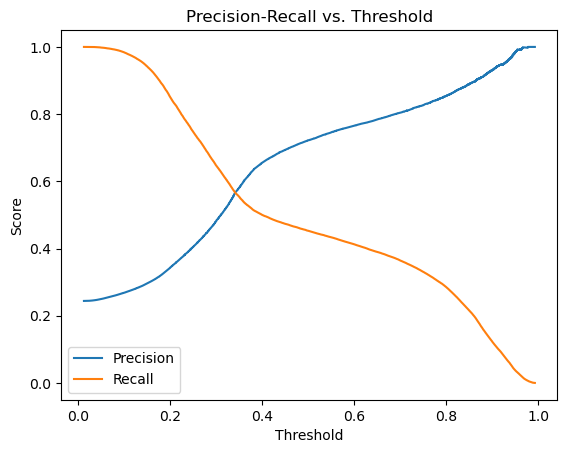

In [571]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot Precision-Recall vs Threshold to choose a balanced threshold
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs. Threshold")
plt.legend()
plt.show()

In [579]:
# Use chosen threshold
optimal_threshold = 0.23  # Adjust based on precision-recall curve, but consider to lower as much as possible - to get more precise Class 1 
y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate with adjusted threshold
accuracy = accuracy_score(y_test, y_pred_adjusted)
class_report = classification_report(y_test, y_pred_adjusted)
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

print(f"Accuracy Score: {accuracy}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy Score: 0.6339806042688526
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.58      0.71    168761
           1       0.38      0.79      0.51     54484

    accuracy                           0.63    223245
   macro avg       0.64      0.69      0.61    223245
weighted avg       0.77      0.63      0.66    223245

Confusion Matrix:
 [[98644 70117]
 [11595 42889]]


I tested several threshold, but seems we have lots of trade-off btw Precision and Recall in Class 1. Overall, we need to improve the f1-score. So lets see how to improve the f1-score

### Fine Tune with GridSearch CV and Threshold Precision-Recall

In [591]:
# Initialize XGBoost model without SMOTE or without scale_pos_weight
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Tune param
param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'scale_pos_weight': [1, scale_pos_weight]
}

random_search = RandomizedSearchCV(
    xgb_model,
    param_grid,
    n_iter=20,  # Number of parameter settings sampled
    scoring='f1',
    cv=3,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 6, 10],
                                        'n_estimators': [50, 100, 200],
                                        'scale_pos_weight': [1, 1.0]},
                   random_state=42, scoring='f1')

In [592]:
# Xgb_Tune model
xgb_tune = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)

# Predict probabilities
y_pred = xgb_tune.predict(X_test)
y_pred_proba = xgb_tune.predict_proba(X_test)[:, 1]

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Best parameters found:  {'scale_pos_weight': 1.0, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
Accuracy Score: 0.8247172389079263
ROC AUC Score: 0.7865940297873046
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89    168761
           1       0.76      0.41      0.54     54484

    accuracy                           0.82    223245
   macro avg       0.80      0.69      0.71    223245
weighted avg       0.82      0.82      0.80    223245

Confusion Matrix:
 [[161582   7179]
 [ 31952  22532]]


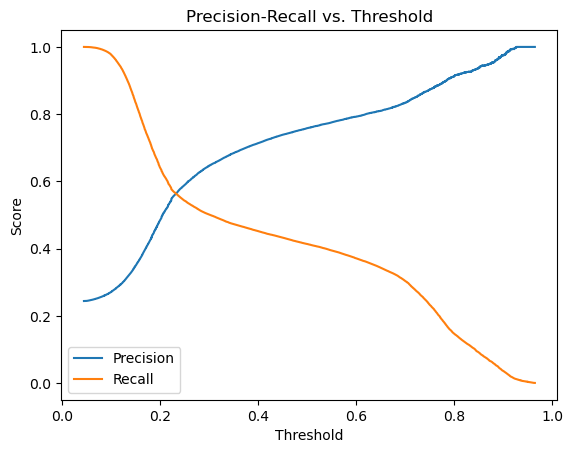

In [586]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot Precision-Recall vs Threshold to choose a balanced threshold
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs. Threshold")
plt.legend()
plt.show()

In [587]:
# Use chosen threshold
optimal_threshold = 0.2  # Adjust based on precision-recall curve, but consider to lower as much as possible - to get more precise Class 1 
y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate with adjusted threshold
accuracy = accuracy_score(y_test, y_pred_adjusted)
class_report = classification_report(y_test, y_pred_adjusted)
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

print(f"Accuracy Score: {accuracy}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy Score: 0.7474120361038321
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.78      0.82    168761
           1       0.49      0.64      0.55     54484

    accuracy                           0.75    223245
   macro avg       0.68      0.71      0.69    223245
weighted avg       0.78      0.75      0.76    223245

Confusion Matrix:
 [[132037  36724]
 [ 19665  34819]]


### Finetune other parameter

In [593]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 6, 9],                    # Regularize complexity
    'learning_rate': [0.01, 0.1, 0.2],         # Balance learning rate and iterations
    'n_estimators': [100, 200, 300],           # Number of trees
    'min_child_weight': [1, 5, 10],            # Control overfitting (higher values reduce overfitting)
    'subsample': [0.6, 0.8, 1.0],              # Fraction of samples used for training each tree
    'colsample_bytree': [0.6, 0.8, 1.0],       # Fraction of features used per tree
    'scale_pos_weight': [scale_pos_weight]     # Imbalance ratio, calculated based on original data
}

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Initialize RandomizedSearchCV with 10 iterations
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=10,                   # Number of parameter combinations to try
    scoring='f1',                # Use f1 score to focus on both precision and recall
    cv=3,                        # 3-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the randomized search on resampled data
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best model and parameters
best_model_3 = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)

# Make predictions with the best model
y_pred_3 = best_model_3.predict(X_test)
y_pred_proba_3 = best_model_3.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_3 = accuracy_score(y_test, y_pred_3)
roc_auc_3 = roc_auc_score(y_test, y_pred_proba_3)
class_report_3 = classification_report(y_test, y_pred_3)
conf_matrix_3 = confusion_matrix(y_test, y_pred_3)

print(f"Accuracy Score: {accuracy_3}")
print(f"ROC AUC Score: {roc_auc_3}")
print("Classification Report:\n", class_report_3)
print("Confusion Matrix:\n", conf_matrix_3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'subsample': 1.0, 'scale_pos_weight': 1.0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Accuracy Score: 0.8207395462384376
ROC AUC Score: 0.7846411591819729
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89    168761
           1       0.70      0.47      0.56     54484

    accuracy                           0.82    223245
   macro avg       0.77      0.70      0.72    223245
weighted avg       0.81      0.82      0.81    223245

Confusion Matrix:
 [[157870  10891]
 [ 29128  25356]]


### Conclusion

- Seems the tune Model_3 have the most accurate one. As we prioritize to detect as many high cancellation stores as possible (prioritize label 1)
- However, Model_3 not improve so much vs Model_1 (with applying SMOTE), also need to trade off with the accuracy of Label 0
- Now, lets see other models like LightGMV or CatBoost. Or using Ensemble technique


### Extract Feature important

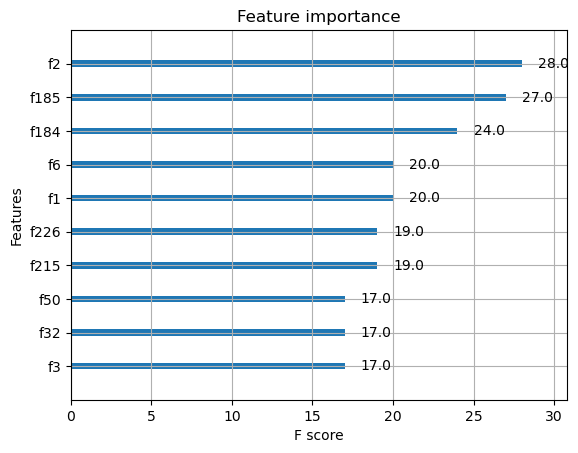

In [90]:
#feature importance

xgb.plot_importance(model, importance_type="weight", max_num_features=10)
plt.show()

In [91]:
# Extract original feature names
feature_names = X_test_origin.columns

# Assign these feature names to X_test
X_test.columns = feature_names

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
X_test.columns

In [ ]:

import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

In [ ]:
# Create a SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
shap.initjs()
# Pick an instance to explain
instance = 0  # for example, the first instance in X_test

# Generate force plot for a single instance
shap.force_plot(explainer.expected_value, shap_values[instance, :], X_test.iloc[instance, :])

In [ ]:
# SHAP dependence plot for a specific feature
shap.dependence_plot("feature_name", shap_values, X_test)

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values[:5], X_test.iloc[:5])  # Analyzes the first 5 instances

## 6-2 LightGBM

### Baseline LightGBM - with SMOTE only, no tuning

In [594]:
# Import necessary libraries
!pip install lightgbm

import lightgbm as lgb

In [597]:
# Define your X_train, X_test, y_train, y_test datasets
# Assuming these are already split

# Step 1: Apply SMOTE to oversample the minority class - Did above in XGBoost

# Step 2: Define the LightGBM model and parameter grid
lgb_model = lgb.LGBMClassifier(objective='binary', random_state=42)

# Fit on the resampled training data
lgb_model.fit(X_train_resampled, y_train_resampled)

# Step 4: Evaluate the model on the test set
y_pred = lgb_model.predict(X_test)
y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]  # Probability predictions for ROC AUC

# Step 5: Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output results
print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

[LightGBM] [Info] Number of positive: 389190, number of negative: 389190
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 778380, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy Score: 0.8246052543170059
ROC AUC Score: 0.7900081141784856
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89    168761
           1       0.73      0.45      0.56     54484

    accuracy                           0.82    223245
   macro avg       0.78      0.70      0.72    223245
weighted avg       0.81      0.82      0.81    223245

Confusion Matrix:
 [[159606   9155]
 [ 30001  24483]]


### Now lets tune

I wont use GridSearchCV this time. Its so time-consuming. Lets go with the RandomSearch option

In [598]:
# Calculate scale_pos_weight based on original training data distribution
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define a smaller, focused parameter grid
param_grid = {
    'max_depth': [6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [scale_pos_weight * 0.5, scale_pos_weight, scale_pos_weight * 2],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    scoring='f1',  # Choose metric based on business needs
    cv=3,
    n_jobs=-1,
    verbose=1,
    n_iter=20,  # Number of random parameter settings to try
    random_state=42
)

# Fit RandomizedSearchCV on the resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Extract the best model
best_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)

# Make predictions and evaluate performance on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability predictions for ROC AUC

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output results
print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 389190, number of negative: 389190
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 778380, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best parameters found:  {'subsample': 1.0, 'scale_pos_weight': 1.0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Accuracy Score: 0.8174919931017492
ROC AUC Score: 0.7806896844943163
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.88    168761
           1       0.68      0.47      0.56     54484


Guess Light GBM no better

## 6-3 CatBoost

### Baseline CatBoost - without SMOTE or Tuning

In [ ]:
!pip install catboost

In [600]:
from catboost import CatBoostClassifier

# Initialize the CatBoost classifier with default parameters
catboost_model = CatBoostClassifier(
    verbose=0,  # Suppress CatBoost output for cleaner logs
    scale_pos_weight=scale_pos_weight  # Set the scale_pos_weight based on original data distribution
)

# Fit the model on the training data (without any SMOTE or tuning)
catboost_model.fit(X_train, y_train)

# Predictions on test data
y_pred = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)


Accuracy Score: 0.8278931219064257
ROC AUC Score: 0.7970012126205176
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.89    168761
           1       0.77      0.42      0.54     54484

    accuracy                           0.83    223245
   macro avg       0.80      0.69      0.72    223245
weighted avg       0.82      0.83      0.81    223245

Confusion Matrix:
 [[161910   6851]
 [ 31571  22913]]


### With Tuning

In [605]:
# Calculate scale_pos_weight based on the original data distribution
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define the parameter grid for CatBoost
param_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [100, 200, 300],
    'scale_pos_weight': [scale_pos_weight * 0.5, scale_pos_weight, scale_pos_weight * 3],
    'l2_leaf_reg': [3, 5, 7],
    'bagging_temperature': [0, 1, 2]
}

# Initialize the CatBoost classifier
catboost_model = CatBoostClassifier(verbose=0)  # verbose=0 suppresses CatBoost output for a cleaner log

# Initialize RandomizedSearchCV with f1 score (focusing on the minority class)
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    scoring=make_scorer(f1_score, pos_label=1),
    cv=3,
    n_jobs=-1,
    verbose=1,
    n_iter=15,  # Limiting to a reasonable number of combinations for efficiency
    random_state=42
)

# Perform RandomizedSearchCV
random_search.fit(X_train, y_train)

# Extract the best model from RandomizedSearchCV
best_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)

# Predictions on test data
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters found:  {'scale_pos_weight': 3.0, 'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 100, 'depth': 6, 'bagging_temperature': 2}
Accuracy Score: 0.803328182042151
ROC AUC Score: 0.782003838825267
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87    168761
           1       0.62      0.52      0.56     54484

    accuracy                           0.80    223245
   macro avg       0.73      0.71      0.72    223245
weighted avg       0.79      0.80      0.80    223245

Confusion Matrix:
 [[151181  17580]
 [ 26326  28158]]


### With SMOTE

In [606]:
# Initialize the CatBoost classifier with default parameters
catboost_model = CatBoostClassifier(
    verbose=0,  # Suppress CatBoost output for cleaner logs
    scale_pos_weight=scale_pos_weight  # Set the scale_pos_weight based on original data distribution
)

# Fit the model on the training data (without any SMOTE or tuning)
catboost_model.fit(X_train_resampled, y_train_resampled)

# Predictions on test data
y_pred = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)


Accuracy Score: 0.8273824721718291
ROC AUC Score: 0.7952211878560947
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.89    168761
           1       0.76      0.43      0.55     54484

    accuracy                           0.83    223245
   macro avg       0.80      0.69      0.72    223245
weighted avg       0.82      0.83      0.81    223245

Confusion Matrix:
 [[161180   7581]
 [ 30955  23529]]


### With SMOTE + Tune

In [607]:
# Define an adjusted parameter grid for CatBoost tuning
param_grid = {
    'iterations': [200, 300, 400],  # Increasing iterations
    'learning_rate': [0.05, 0.1],   # Higher learning rate options
    'depth': [4, 6, 8],             # Broader depth range
    'l2_leaf_reg': [3, 5, 7]        # Regularization range
}

# Initialize the CatBoost classifier without scale_pos_weight
catboost_model = CatBoostClassifier(
    verbose=0,         # Suppress training logs
    random_seed=42
)

# Use RandomizedSearchCV with balanced accuracy for a more balanced approach
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1,
    n_iter=15,   # Testing 15 random combinations
    random_state=42
)

# Fit the model with RandomizedSearchCV
random_search.fit(X_train_resampled, y_train_resampled)

# Evaluate the best model on the test data
best_model = random_search.best_estimator_

# Predictions on the test data
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best parameters found: ", random_search.best_params_)
print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters found:  {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 4}
Accuracy Score: 0.8220699231785706
ROC AUC Score: 0.7874167884253556
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89    168761
           1       0.71      0.45      0.55     54484

    accuracy                           0.82    223245
   macro avg       0.78      0.70      0.72    223245
weighted avg       0.81      0.82      0.81    223245

Confusion Matrix:
 [[158787   9974]
 [ 29748  24736]]


## 6-4 Random Forest

### Baseline Random Forest - No Tuning, No SMOTE

In [608]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,  # You can adjust this number if needed
    max_depth=None,     # No restriction on depth
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True
)

# Fit the model on the training data (no SMOTE, no tuning)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability predictions for ROC AUC

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy Score: 0.8104683195592286
ROC AUC Score: 0.7657129352400623
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.88    168761
           1       0.67      0.44      0.53     54484

    accuracy                           0.81    223245
   macro avg       0.75      0.69      0.71    223245
weighted avg       0.80      0.81      0.80    223245

Confusion Matrix:
 [[156963  11798]
 [ 30514  23970]]


### With SMOTE

In [609]:
# Fit the model on the resampled training data
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability predictions for ROC AUC

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy Score: 0.8040941566440458
ROC AUC Score: 0.7620040688994295
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.88    168761
           1       0.63      0.48      0.54     54484

    accuracy                           0.80    223245
   macro avg       0.74      0.69      0.71    223245
weighted avg       0.79      0.80      0.79    223245

Confusion Matrix:
 [[153494  15267]
 [ 28468  26016]]


### With SMOTE and Tuning

It will take so long to do the tuning. Instead, we do the CV

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=5, scoring='f1')

# Print the cross-validation scores
print("Cross-validation F1 scores:", cv_scores)
print("Mean F1 score:", cv_scores.mean())

# Fit the model on the entire resampled training data
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = cv_scores.predict(X_test)
y_pred_proba = cv_scores.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy Score: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Cross-validation F1 scores: [0.57200243 0.6853201  0.94086955 0.93581821 0.93513279]
Mean F1 score: 0.8138286170197073
Accuracy Score: 0.8040941566440458
ROC AUC Score: 0.7620040688994295
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.88    168761
           1       0.63      0.48      0.54     54484

    accuracy                           0.80    223245
   macro avg       0.74      0.69      0.71    223245
weighted avg       0.79      0.80      0.79    223245

Confusion Matrix:
 [[153494  15267]
 [ 28468  26016]]
